In [1]:
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import re
import numpy as np
from matplotlib import gridspec
import matplotlib

# Helper functions

These are borrowed from the `Convert.ipynb` file.

In [2]:
headings = ['Building Identifier',
            'Country',
             'City',
             'Quality / Stage of Data',
             'Construction Date',
             'Building Type',
             'Gross Floor Area']

In [3]:
df = pd.read_excel('../Dataset/dataset.xlsx',header=1).drop('Unnamed: 0',axis=1)

In [4]:
df

,Building Identifier,Country,City,Quality / Stage of Data,Construction Date,Building Type,Gross Floor Area,000_G2010.20.000_03 00 00.00_kg_1,000_B1010.20.000_03 00 00.00_kg_1,000_C1010.10.000_04 22 00.00_kg_1,...,000_B2010.10.000_07 46 16.00_kg_2.1,001_B2010.80.000_07 27 00.00_kg_2.1,001_B2010.80.000_07 21 13.00_kg_2.1,001_B2010.10.000_09 24 23.00_kg_2.1,0B1_A5020.10.000_06 11 00.00_kg_2.1,0B1_A5020.10.000_06 11 00.00_kg_1.1,0B1_A5020.10.000_09 21 16.00_kg_1.1,000_C1010.10.000_07 21 13.00_kg_1.1,00R_B3010.90.000_07 21 13.00_kg_1.1,00R_B1020.20.000_07 51 13.00_kg_1.1
0,1,CA,TOR,00IFC,2021,SND,521.18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,CA,TOR,00IFC,2021,SND,389.24,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,CA,TOR,00IFC,2021,SND,411.64,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,CA,TOR,00IFC,2021,SND,269.56,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,CA,TOR,00IFC,2011,OFF,11248.00,13704.0,1.776816e+06,19397.560000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,CA,TOR,00IFC,2011,APB,11317.00,NaN,1.514400e+06,53877.650000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,CA,TOR,00IFC,2021,SND,445.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,CA,TOR,00IFC,2021,SND,438.45,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,CA,TOR,00IFC,2021,SND,714.07,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,CA,TOR,00IFC,2021,SND,343.24,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
name_conversion = pd.read_csv('name_conversion.csv')
building_name_conversion = pd.read_csv('building_type_name_conversion.csv')

In [6]:
building_name_map = {k['Building Code']:k['Building Type'] for _,k in building_name_conversion.iterrows()}

In [7]:
name_map = {k.Code:k.Category for _,k in name_conversion.iterrows()}

In [8]:
additional_categories_map = {v:k for k,v in {
    'Continuous Footings':'0CF',
    'Foundation Walls':'0FW',
    'Spread Footings':'0SF',
    'Column Piers':'0CP',
    'Columns Supporting Floors':'CSF',
    'Floor Girders and Beams':'FGB',
    'Floor Trusses':'0FT',
    'Floor Joists':'0FJ',
    'Columns Supporting Roofs':'CSR',
    'Roof Girders and Beams':'RGB',
    'Roof Trusses':'0RT',
    'Roof Joists':'0RJ',
    'Parking Bumpers':'0PB',
    'Precast Concrete Stair Treads':'PCS',
    'Roof Curbs':'0RC',
    'Exterior Wall Construction':'EWC',
    'Composite Decking':'CPD',
    'Cast-in-Place concrete':'CIC',
    'Floor Structural Frame':'FSF',
    'Associated Metal Fabrications':'AMF',
    'Floor Construction Supplementary Components':'FCS',
    'Roof Construction Supplementary Components':'RCS',
    'Residential Elevators':'0RE',
    'Vegetated Low-Slope Roofing':'VLR',
    'Swimming Pools':'SWP',
    'Excavation Soil Anchors':'ESA',
    'Floor Trusses':'FTS',
    'Roof Window and Skylight Performance':'RWS',
    'Rainwater Storage Tanks':'RST',
    'Gray Water Tanks':'GWT'}.items()
}

additional_categories_map['0FT'] = 'Floor Trusses'

# 1. Plot sample figures

Here we plot building material mass.

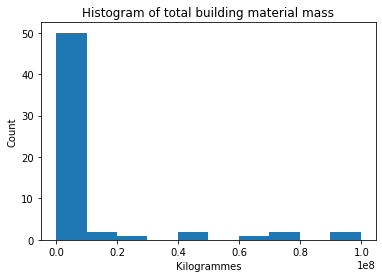

In [9]:
plt.hist(df[[c for c in df.columns if 'kg' in c]].sum(axis=1));
plt.title('Histogram of total building material mass')
plt.xlabel('Kilogrammes')
plt.ylabel('Count');

# 2. Investigate a specific material

In this example, we select only columns that match the MasterFormat code for Structural Concrete. Then, we aggregate based on Level 2 UniFormat code.

In [10]:
cols = [d for d in df.columns if '03 31 00' in d]

In [11]:
f = lambda x: re.split('[_\.\ ]',x)[1][0:3]
concrete_df = pd.concat([df[headings],df[cols].groupby(f,axis=1).sum()],axis=1).rename(columns=name_map)

In [12]:
concrete_df

,Building Identifier,Country,City,Quality / Stage of Data,Construction Date,Building Type,Gross Floor Area,Foundations,Subgrade Enclosures,Slabs-On-Grade,Substructure Interior,Substructure Related Activities,Superstructure,Exterior Vertical Enclosures,Exterior Horizontal Enclosures,Interior Construction,Conveying,Plumbing,Special Construction,Site Improvements
0,1,CA,TOR,00IFC,2021,SND,521.18,1.709236e+05,0.0,6.721219e+04,0.0,0.0,1.938810e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,CA,TOR,00IFC,2021,SND,389.24,1.082862e+05,0.0,3.576043e+04,0.0,0.0,1.397610e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,CA,TOR,00IFC,2021,SND,411.64,1.909299e+05,0.0,3.246461e+04,0.0,0.0,1.528710e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,CA,TOR,00IFC,2021,SND,269.56,6.736923e+04,0.0,1.595211e+04,0.0,0.0,1.212090e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,CA,TOR,00IFC,2011,OFF,11248.00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,CA,TOR,00IFC,2011,APB,11317.00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,CA,TOR,00IFC,2021,SND,445.99,1.295202e+05,0.0,3.521918e+04,0.0,0.0,5.332590e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,CA,TOR,00IFC,2021,SND,438.45,1.174431e+05,0.0,4.289057e+04,0.0,0.0,1.970790e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,CA,TOR,00IFC,2021,SND,714.07,1.927680e+05,0.0,8.446873e+04,0.0,0.0,4.049670e+03,0.0,0.0,11307.2,0.0,0.0,0.0,0.0
9,10,CA,TOR,00IFC,2021,SND,343.24,9.564723e+04,0.0,2.033114e+04,0.0,0.0,9.440170e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0


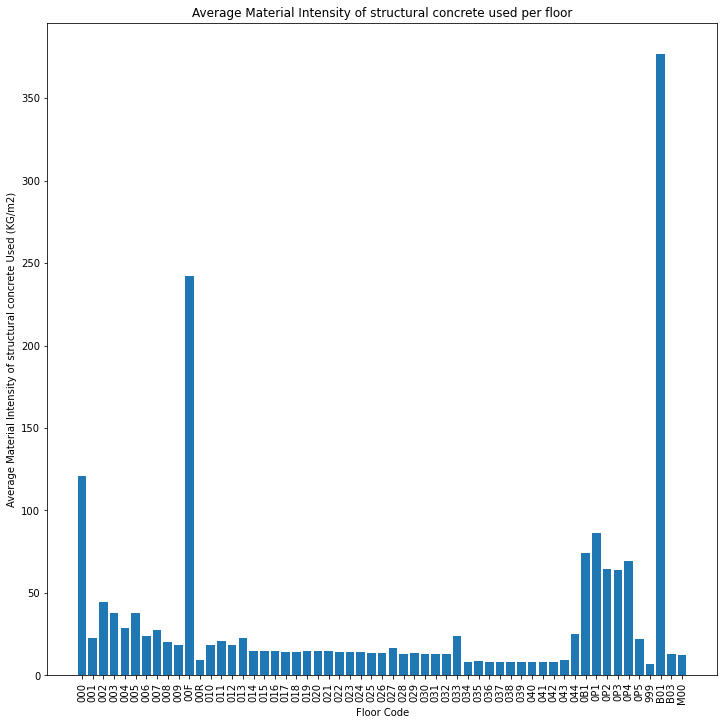

In [13]:
grouping_function = lambda x: x.split('_')[0] #This function takes in a full column name, like "000_G2010.20.000_03 00 00.00_m3_1", and returns only the floor.
to_draw = df[cols].groupby(grouping_function,axis=1).sum().replace(0,np.NaN).div(df['Gross Floor Area'],axis='rows').mean()
plt.figure(figsize=(12,12))
plt.bar(to_draw.keys(), to_draw.values)
plt.xticks(rotation=90)
plt.title('Average Material Intensity of structural concrete used per floor')
plt.ylabel('Average Material Intensity of structural concrete Used (KG/m2)')
plt.xlabel('Floor Code');

Now, we will aggregate to Level 3 MasterFormat codes, and display these values for the first three entries.

In [14]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0:3]] #This function takes in a full column name and returns only the Level 3 MasterFormat code.
concrete_df = df[cols].groupby(f,axis=1).sum()

In [15]:
concrete_df.mean().sort_values(ascending=False)

Superstructure                     2.156826e+06
Substructure Interior              1.016670e+06
Foundations                        6.750260e+05
Interior Construction              5.426285e+05
Subgrade Enclosures                2.447624e+05
Conveying                          1.525784e+05
Slabs-On-Grade                     9.043012e+04
Exterior Vertical Enclosures       2.899600e+04
Exterior Horizontal Enclosures     2.883760e+04
Substructure Related Activities    1.309240e+04
Special Construction               6.064400e+03
Plumbing                           5.850000e+03
Site Improvements                  1.932400e+03
dtype: float64

## Pie chart version A: on-pie chart labels for all > 1%

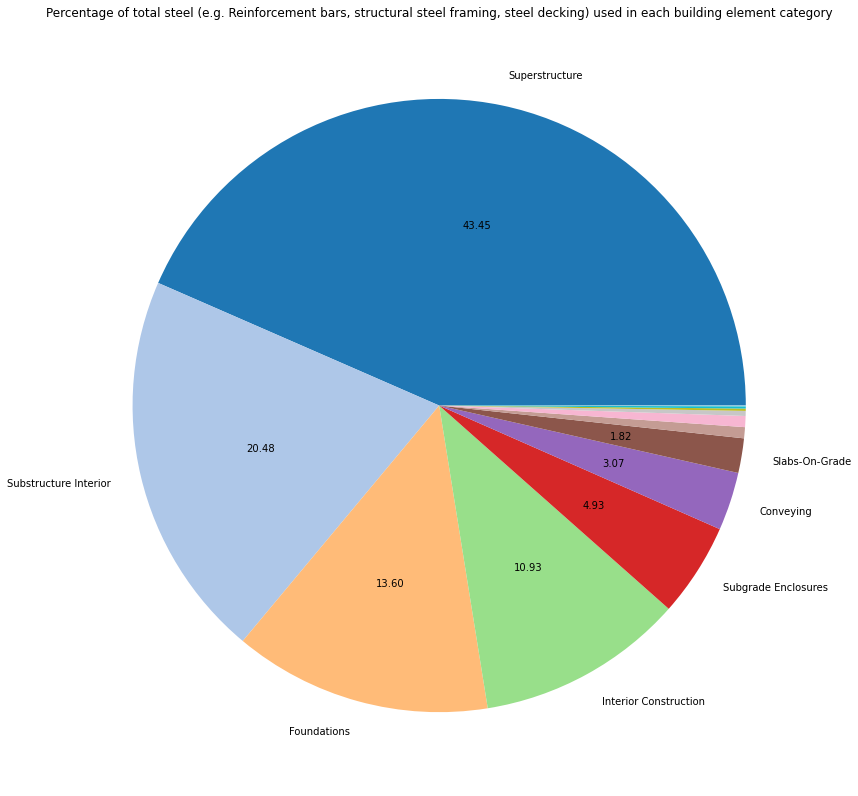

In [16]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = concrete_df.mean().sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct,labels=[k if v > 30000 else '' for k,v in to_plot.items()])
plt.ylabel('')
plt.title('Percentage of total steel (e.g. Reinforcement bars, structural steel framing, steel decking) used in each building element category');
# plt.legend(loc='center left',bbox_to_anchor=(-0.20, 0.75));
plt.tight_layout();

## Pie version B: external legend with slice labels

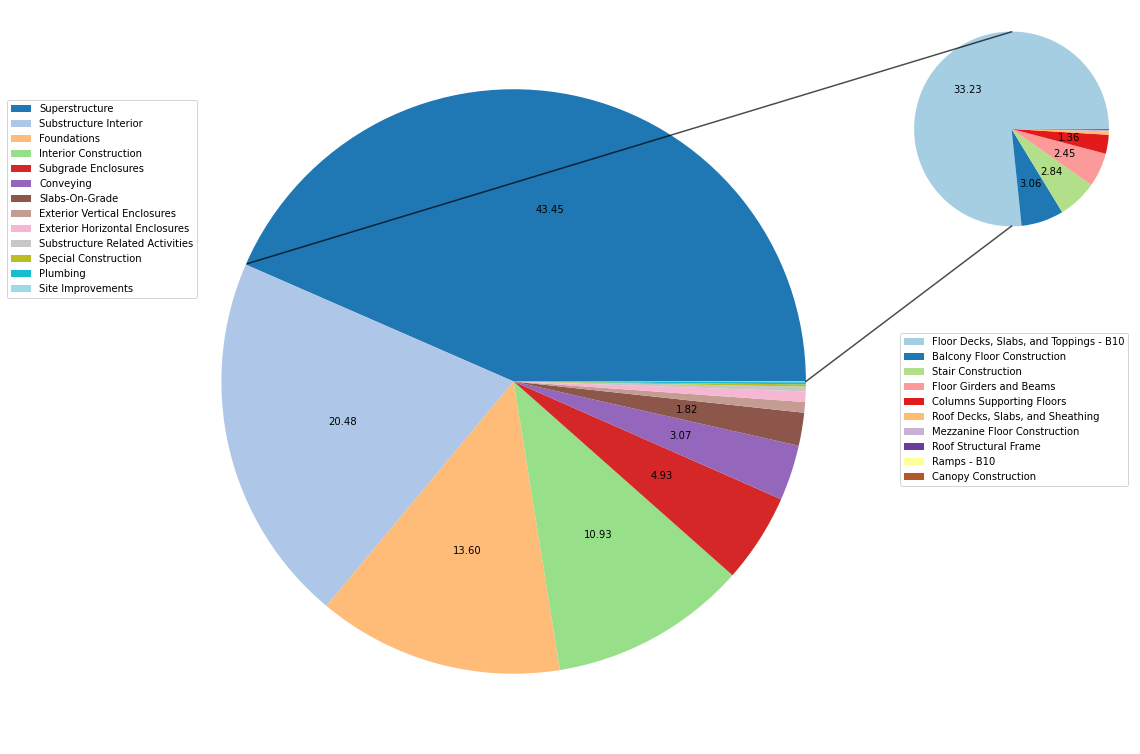

In [17]:
fig = plt.figure(figsize=(16,12)) 
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])
ax0 = plt.subplot(gs[:,0])

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = concrete_df.mean().sort_values(ascending=False)
to_plot.plot.pie(ax=ax0,colormap='tab20',autopct=my_autopct,labeldistance=None)
plt.ylabel('')
plt.legend(loc='center left',bbox_to_anchor=(-0.20, 0.75));
plt.tight_layout();

ax1 = plt.subplot(gs[0,1])
f = lambda x: \
    additional_categories_map[re.split('[_\.\ ]',x)[3]] \
    if \
    re.split('[_\.\ ]',x)[3] != '000' \
    else \
    name_map['.'.join(re.split('[_\.\ ]',x)[1:3])]

superstructure_df = df[[c for c in cols if 'B10' in c]].groupby(f,axis=1).sum()
to_plot = superstructure_df.mean().sort_values(ascending=False)
def my_autopct(pct):
    return ('%.2f' % ((pct * 0.4335))) if pct > 1 else ''
to_plot.plot.pie(ax=ax1,colormap='Paired',autopct=my_autopct,labeldistance=None)
plt.ylabel('')
plt.legend(loc='center right',bbox_to_anchor=(1, -0.65));
plt.tight_layout();

transFigure = fig.transFigure.inverted()

coord1a = transFigure.transform(ax0.transData.transform([1,0]))
coord2a = transFigure.transform(ax1.transData.transform([0,-0.72]))

coord1b = transFigure.transform(ax0.transData.transform([-0.91,0.35]))
coord2b = transFigure.transform(ax1.transData.transform([0,0.72]))

linea = matplotlib.lines.Line2D((coord1a[0],coord2a[0]),(coord1a[1],coord2a[1]),
                               transform=fig.transFigure,c='black',alpha=0.7)
lineb = matplotlib.lines.Line2D((coord1b[0],coord2b[0]),(coord1b[1],coord2b[1]),
                                transform=fig.transFigure,c='black',alpha=0.7)
fig.lines = linea,lineb,

plt.savefig('concrete_breakdown_pie.pdf')

We can produce a pie chart for a single building, also.

In [18]:
mf_codes = pd.read_csv('mf_name_conversion.csv')

In [19]:
tofind = [
    'Plain Steel Reinforcement Bars',
    'Reinforcement Bars',
    'Structural Steel Framing',
    'Fabric and Grid Reinforcing',
    'Metal Doors',
    'Metal Roof Panel',
    'Metal Stairs',
    'Metal Railings',
    'Steel Decking',
    'Steel Joist Framing',
    'Steel'
] #List of terms we are looking to identify in column names.

tokeep = [
    c for c in mf_codes.Title.values if any(t in c for t in tofind)
] #For each codes' corresponding in MasterFormat

steel_codes = mf_codes[mf_codes.Title.isin(tokeep)]

In [20]:
columns_to_keep = []
for column in df.columns:
    if 'kg' in column:
        code = re.split('_',column)[2]
        for k,c in steel_codes.values:
            if c in code:
                columns_to_keep.append(column)

In [21]:
f = lambda x: mf_codes[mf_codes.Code == str.replace(re.split('_',x)[2],'00','').strip('.')].values[0][0]
steel_df = df[columns_to_keep].groupby(f,axis=1).sum()

In [22]:
(steel_df>0).sum(axis=1).sort_values()

15    1
42    1
22    1
36    1
7     1
34    1
31    1
35    1
55    2
58    2
40    2
41    2
1     2
43    2
24    2
23    2
21    2
20    2
54    2
44    2
17    2
16    2
30    2
14    2
45    2
12    2
11    2
32    2
9     2
33    2
3     2
18    2
0     3
52    3
53    3
56    3
46    3
39    3
29    3
37    3
28    3
27    3
26    3
25    3
13    3
10    3
2     3
38    3
5     3
6     3
8     3
57    4
4     4
49    4
50    4
48    4
47    4
19    4
51    4
59    4
dtype: int64

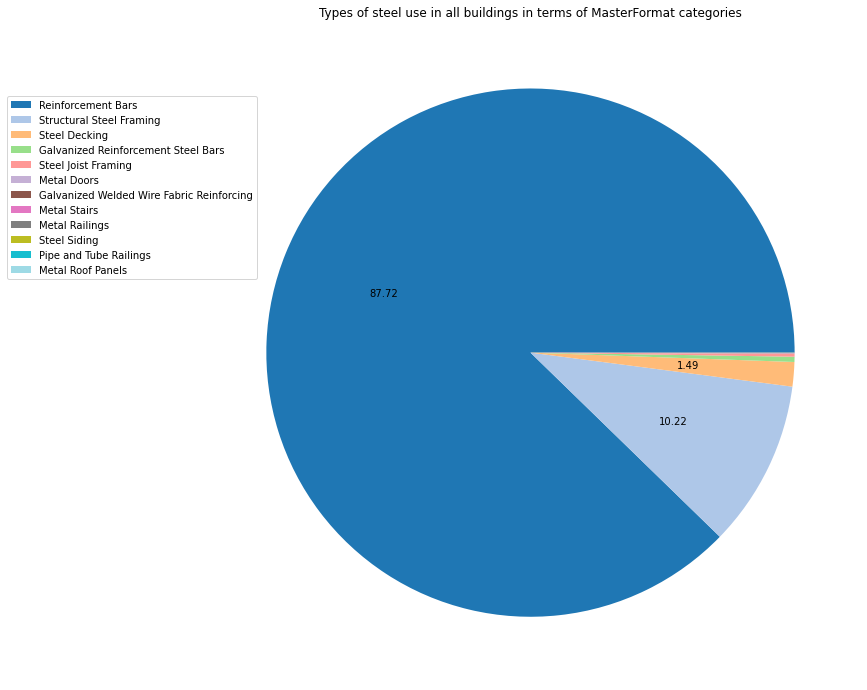

In [23]:
def my_autopct(pct):
    return ('%.2f' % (pct)) if pct > 1 else ''
to_plot = steel_df.sum().sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct,labeldistance=None)
plt.legend(loc='center left',bbox_to_anchor=(-0.30, 0.75));

plt.ylabel('')
plt.title(f'Types of steel use in all buildings in terms of MasterFormat categories');
plt.tight_layout();

plt.savefig('steel_composition_pie.pdf')

In [24]:
f = lambda x: mf_codes[mf_codes.Code == str.replace(re.split('_',x)[2],'00','').strip('.')].values[0][0] + '/' + x.split('_')[0]
tdf = df[columns_to_keep].groupby(f,axis=1).sum().iloc[47,:]
tdf = tdf[tdf>0]

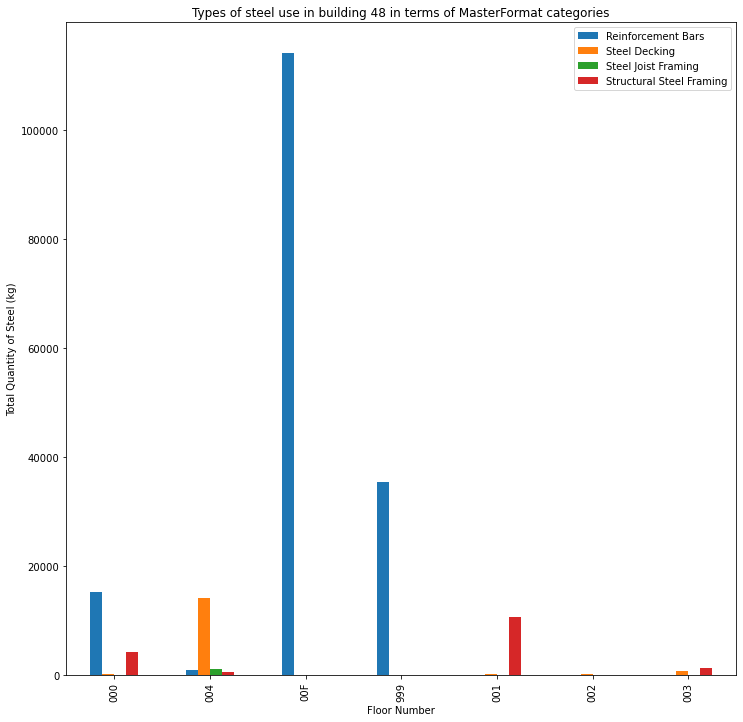

In [25]:
from collections import defaultdict
todf = defaultdict(dict)
for (a,b),c in zip(tdf.keys().str.split('/'),tdf.values):
    todf[a][b] = c
toplot = pd.DataFrame(todf)
toplot.plot.bar(figsize=(12,12));
plt.xlabel('Floor Number')
plt.ylabel('Total Quantity of Steel (kg)')
plt.title('Types of steel use in building 48 in terms of MasterFormat categories')
plt.savefig('bar_steel_onebuildingtype_byfloor.pdf')

We can also calculate the average for each Level 3 MasterFormat code by year of construction:

In [26]:
concrete_df = pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1)
concrete_df.groupby('Construction Date').mean()

,Gross Floor Area,Structural Concrete/000,Structural Concrete/001,Structural Concrete/002,Structural Concrete/003,Structural Concrete/004,Structural Concrete/005,Structural Concrete/006,Structural Concrete/007,Structural Concrete/008,...,Structural Concrete/0B1,Structural Concrete/0P1,Structural Concrete/0P2,Structural Concrete/0P3,Structural Concrete/0P4,Structural Concrete/0P5,Structural Concrete/999,Structural Concrete/B01,Structural Concrete/B03,Structural Concrete/M00
Construction Date,,,,,,,,,,,,,,,,,,,,,
1913,161.080000,0.000000e+00,1944.380000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,64035.190000,0.000000,0.0
1917,199.930000,0.000000e+00,4972.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,114018.460000,0.000000,0.0
1969,373.605000,0.000000e+00,7262.220500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,132278.015000,0.000000,0.0
1988,21934.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2007,73600.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2009,73083.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2011,11282.500000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2016,30345.000000,3.595656e+06,0.000000,2680512.0,1686228.0,1057032.0,1056780.0,1129680.0,1809852.0,857976.0,...,0.000000,2206668.0,1715028.0,1596444.0,0.0,0.0,155076.0,0.000000,0.000000,82056.0
2017,39392.013333,4.084352e+06,0.000000,989280.0,1232336.0,778480.0,683496.0,679376.0,632520.0,651080.0,...,0.000000,3402456.0,2513320.0,2469984.0,1895672.0,508328.0,7736.0,0.000000,0.000000,0.0


We can get the average amount of steel in KG used per building type:

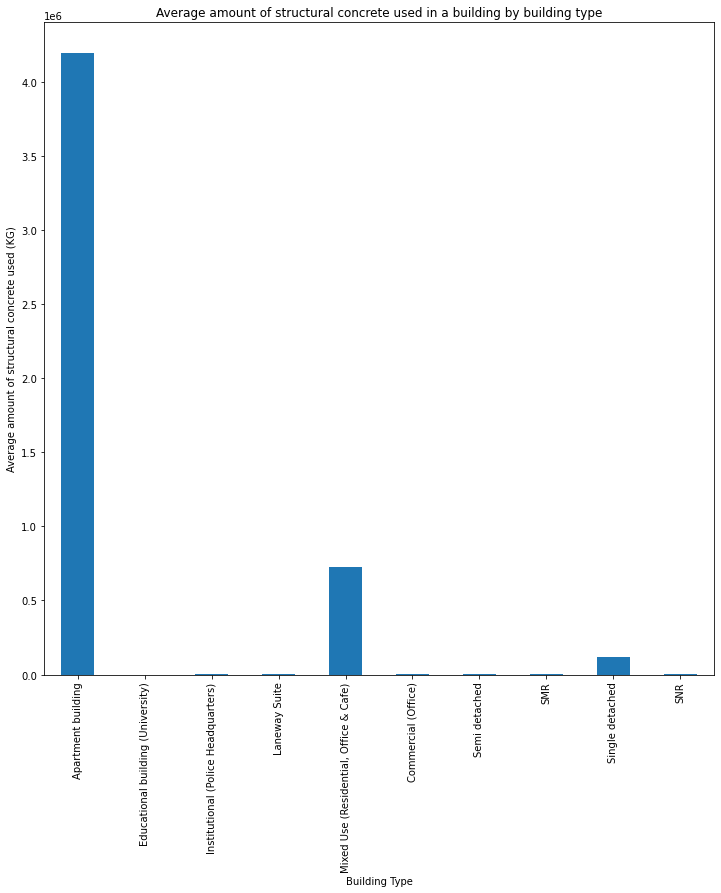

In [27]:
concrete_df.groupby('Building Type').sum().mean(axis=1).rename(index=building_name_map).plot(kind='bar',figsize=(12,12))
plt.ylabel('Average amount of structural concrete used (KG)')
plt.title('Average amount of structural concrete used in a building by building type');

# 3. Uncertainty by Building Type

In this section, we look at the uncertainty score associated with each material takeoff. We collect these by building type and then report the number of each value per type of building.

In [28]:
uncertainty_level = {} 
for k,v in df.iterrows():
    #Initialise empty lists for each building type as they occur
    if v['Building Type'] not in uncertainty_level.keys():
        uncertainty_level[v['Building Type']] = []
    #Append the uncertainty value for each column that is non-NaN
    for key in v[~v.isna()].keys()[7:]:
        uncertainty_level[v['Building Type']].append(key.split('_')[-1])

In [29]:
from collections import Counter

In [30]:
for k,v in uncertainty_level.items():
    uncertainty_level[k] = Counter(v) #Construct a Counter object per building type

In [31]:
uncertainty_level

{'SND': Counter({'1': 1662, '2': 641, '4': 293}),
 'OFF': Counter({'1': 494, '3': 307}),
 'APB': Counter({'1': 1156, '2': 1, '3': 976}),
 'SMR': Counter({'1': 21, '2': 27, '4': 8}),
 'SNR': Counter({'1': 58, '2': 70, '4': 56}),
 'SMD': Counter({'1': 170, '2': 34, '4': 19}),
 'EDU': Counter({'1': 93, '3': 24, '2': 6}),
 'INS': Counter({'1': 90, '3': 77, '2': 1}),
 'MIX': Counter({'1': 363, '3': 276}),
 'LNW': Counter({'2': 46, '1': 142, '4': 19, '2.1': 9, '1.1': 7})}

Next, we aggregate columns by the purporse of the material and uncertainty combined, and report the average by building type.

In [32]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]] + '/' + x.split('_')[-1].split('.')[0] #From a full code, return only the use code and uncertainty score.
by_function_df = pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1)

In [33]:
by_function_df.groupby('Building Type').mean().rename(index=building_name_map).drop(['Construction Date'],axis=1).round(2)

,Gross Floor Area,Interiors/1,Services/1,Shell/1,Shell/2,Sitework/1,Special Construction And Demolition/1,Substructure/1,Substructure/2
Building Type,,,,,,,,,
Apartment building,45505.41,5330644.8,1525512.0,21949118.40,0.00,23188.8,60316.8,20539176.00,0.00
Educational building (University),7901.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00
Institutional (Police Headquarters),21934.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00
Laneway Suite,150.01,0.0,0.0,0.00,0.00,0.0,0.0,60068.14,44.81
"Mixed Use (Residential, Office & Cafe)",33975.25,5893176.0,1878144.0,23063160.00,0.00,0.0,62280.0,11822352.00,0.00
Commercial (Office),52643.67,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00
Semi detached,248.84,0.0,0.0,1864.27,0.00,0.0,0.0,97640.84,0.00
SMR,199.93,0.0,0.0,0.00,0.00,0.0,0.0,110089.90,8900.86
Single detached,478.40,305.6,0.0,1547.01,13.19,0.0,0.0,180887.68,5347.87


Next, we report the total amount of material falling under each uncertainty score by year of construction.

In [34]:
f = lambda x: x.split('_')[-1].split('.')[0] #Select only the uncertainty score.
print('Average amount of material used per building, by year and uncertainty score (%)')
result = pd.concat([df['Construction Date'],df[[c for c in df.columns if 'kg' in c]].groupby(f,axis=1).sum()],axis=1).groupby('Construction Date').mean()
for k,v in result.iterrows():
    result.loc[k,:] = v/v.sum()
display(result.round(2))

Average amount of material used per building, by year and uncertainty score (%)


,1,2,3,4
Construction Date,,,,
1913,0.85,0.08,0.00,0.07
1917,0.75,0.14,0.00,0.11
1969,0.50,0.37,0.00,0.13
1988,0.97,0.00,0.03,0.00
2007,0.97,0.00,0.03,0.00
2009,0.97,0.00,0.03,0.00
2011,0.94,0.03,0.03,0.00
2016,0.95,0.02,0.02,0.00
2017,0.97,0.00,0.03,0.00


# 4. Material Intensity

We can easily calculate material intensity by dividing takeoffs which are measured in kilograms by the `Gross Floor Area`:

In [35]:
kilogram_columns = [d for d in df.columns if 'kg' in d]
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)

In [36]:
kilogram_columns = [d for d in df.columns if 'kg' in d]
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0:3]]
pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1)[df['Building Type'] == 'SND']

,Country,City,Quality / Stage of Data,Construction Date,Building Type,Gross Floor Area,Conveying,Exterior Horizontal Enclosures,Exterior Vertical Enclosures,Foundations,...,Interior Finishes,Plumbing,Site Improvements,Slabs-On-Grade,Special Construction,Subgrade Enclosures,Substructure Interior,Substructure Related Activities,Superstructure,Water And Gas Mitigation
0,CA,TOR,00IFC,2021,SND,521.18,0.0,11.137992,136.939623,335.649367,...,8.309413,0.0,0.0,273.972401,0.0,9.652903,0.000000,0.0,30.228003,0.0
1,CA,TOR,00IFC,2021,SND,389.24,0.0,5.461939,69.018253,281.318698,...,6.490936,0.0,0.0,192.874465,0.0,6.851955,0.000000,0.0,26.271523,0.0
2,CA,TOR,00IFC,2021,SND,411.64,0.0,3.786074,101.450370,464.462195,...,4.574905,0.0,0.0,170.733356,0.0,11.298572,0.000000,0.0,23.756286,0.0
3,CA,TOR,00IFC,2021,SND,269.56,0.0,6.503479,188.215196,255.359136,...,8.510443,0.0,0.0,124.186526,0.0,4.351465,0.000000,0.0,30.517748,0.0
6,CA,TOR,00IFC,2021,SND,445.99,0.0,11.933511,61.325975,295.116668,...,6.391063,0.0,0.0,153.061618,0.0,9.478642,0.054452,0.0,39.906513,0.0
7,CA,TOR,00IFC,2021,SND,438.45,0.0,12.707195,130.552921,269.468463,...,6.584780,0.0,0.0,211.910108,0.0,4.218921,0.000000,0.0,39.907474,0.0
8,CA,TOR,00IFC,2021,SND,714.07,0.0,12.865930,104.310510,276.917123,...,6.563894,0.0,0.0,266.709576,0.0,8.902623,0.000000,0.0,38.291591,0.0
9,CA,TOR,00IFC,2021,SND,343.24,0.0,4.300619,210.632241,283.893850,...,8.940907,0.0,0.0,138.510228,0.0,9.601245,0.000000,0.0,35.370538,0.0
12,CA,TOR,00IFC,2021,SND,226.89,0.0,12.424245,186.668275,261.874926,...,6.134611,0.0,0.0,129.263543,0.0,3.818403,0.935612,0.0,35.355314,0.0
13,CA,TOR,00IFC,2021,SND,611.73,0.0,5.140200,102.332008,343.714248,...,7.638991,0.0,0.0,165.513154,0.0,7.722754,0.000000,0.0,33.388004,0.0


In [37]:
master_format_convert = {v:k for k,v in {
    'Concrete':'03',
    'Masonry':'04',
    'Metals':'05',
    'WoodPlasticsAndComposites':'06',
    'ThermalAndMoistureProtection':'07',
    'Finishes':'09',
    'Openings':'08',
    'Earthwork':'31',
    'ExteriorImprovements':'32'
}.items() }

In [38]:
f = lambda x: master_format_convert[re.split('[_\.\ ]',x)[4]]
toplot = pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1).sort_values(['Building Type'])

In [39]:
types_to_keep = ['APB','SND','SNR','SMR','SMD','ADU','SEC','ROW','LNW']
toplot = toplot[toplot['Building Type'].isin(types_to_keep)]
building_type_map = {
    'APB':'Mid to high-rise buildings',
    'SND':'Newly Constructed Single family dwellings',
    'SNR':'Renovated Single family dwellings',
    'SMD':'Newly Constructed Single family dwellings',
    'SMR':'Renovated Single family dwellings',
    'ADU':'Newly Constructed Single family dwellings',
    'SEC':'Newly Constructed Single family dwellings',
    'ROW':'Newly Constructed Single family dwellings',
    'LNW':'Laneway Houses'
}

toplot['Building Type'] = toplot['Building Type'].replace(building_type_map)
toplot = toplot.sort_values('Building Type')

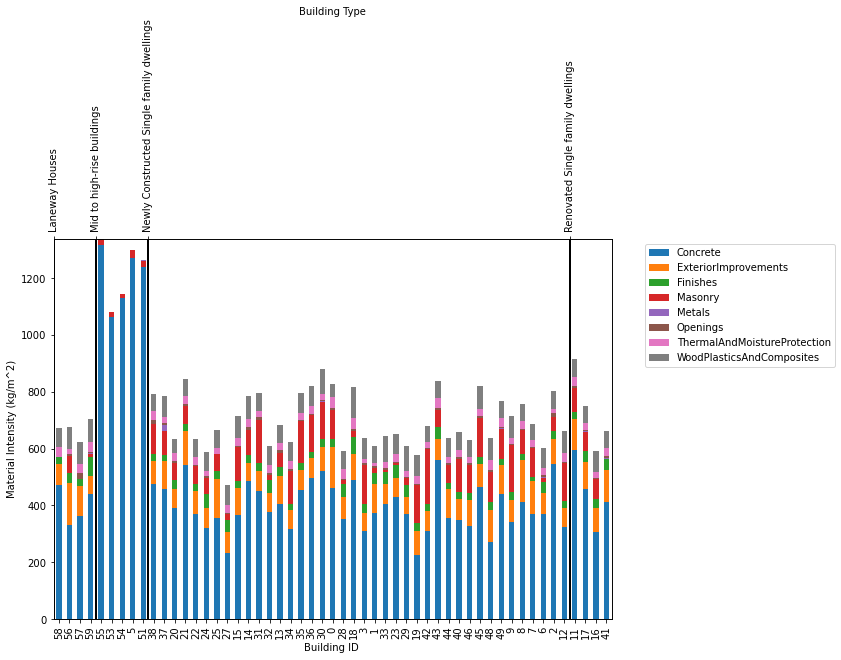

In [40]:
fig, ax = plt.subplots(figsize=(10,7))  

cols = toplot.columns[6:]
margin_bottom = np.zeros(len(toplot))

cmap = plt.get_cmap('tab10')

for num, col in enumerate(cols):
    values = toplot[col].values

    toplot[col].plot.bar(x='Year',y='Value', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=cmap(num), label=col)
    margin_bottom += values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Material Intensity (kg/m^2)')
plt.xlabel('Building ID ')
ax2 = ax.twiny()
ax2.set_xlim(0, len(toplot))
ax2.set_xticks([k for k,v in enumerate(toplot['Building Type'].values) if v != toplot['Building Type'].values[k-1] or k==0])
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
ax2.set_xticklabels([v for k,v in enumerate(toplot['Building Type'].values) if v != toplot['Building Type'].values[k-1] or k==0])
ax2.set_xlabel("Building Type")
plt.grid(color='black',linewidth=2)

plt.show()


In [41]:
toplot['Total MI'] = toplot.iloc[:,6:].sum(axis=1)

In [42]:
print('Mean Material Intensity:')
display(toplot.groupby('Building Type').mean().iloc[:,1:].round(2))
print('Std Dev Material Intensity:')
display(toplot.groupby('Building Type').std().iloc[:,1:].round(2))

Mean Material Intensity:


,Gross Floor Area,Concrete,ExteriorImprovements,Finishes,Masonry,Metals,Openings,ThermalAndMoistureProtection,WoodPlasticsAndComposites,Total MI
Building Type,,,,,,,,,,
Laneway Houses,150.01,402.07,97.09,37.20,17.83,0.26,9.62,28.17,76.52,668.75
Mid to high-rise buildings,45505.41,1204.29,0.00,0.00,19.81,0.69,0.00,0.00,0.00,1224.79
Newly Constructed Single family dwellings,461.18,396.71,86.16,31.17,83.77,0.96,5.99,25.63,68.82,699.22
Renovated Single family dwellings,277.06,442.97,100.30,33.64,55.31,0.74,5.84,26.98,64.59,730.36


Std Dev Material Intensity:


,Gross Floor Area,Concrete,ExteriorImprovements,Finishes,Masonry,Metals,Openings,ThermalAndMoistureProtection,WoodPlasticsAndComposites,Total MI
Building Type,,,,,,,,,,
Laneway Houses,62.86,65.17,37.25,18.91,27.54,0.52,9.08,8.45,6.94,32.99
Mid to high-rise buildings,21930.72,103.88,0.00,0.00,5.50,0.58,0.00,0.00,0.00,108.76
Newly Constructed Single family dwellings,168.17,82.14,22.30,9.40,49.26,3.35,2.21,6.14,11.58,95.96
Renovated Single family dwellings,117.28,120.26,12.94,6.38,37.88,0.86,1.43,5.44,6.55,140.02


In [43]:
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)

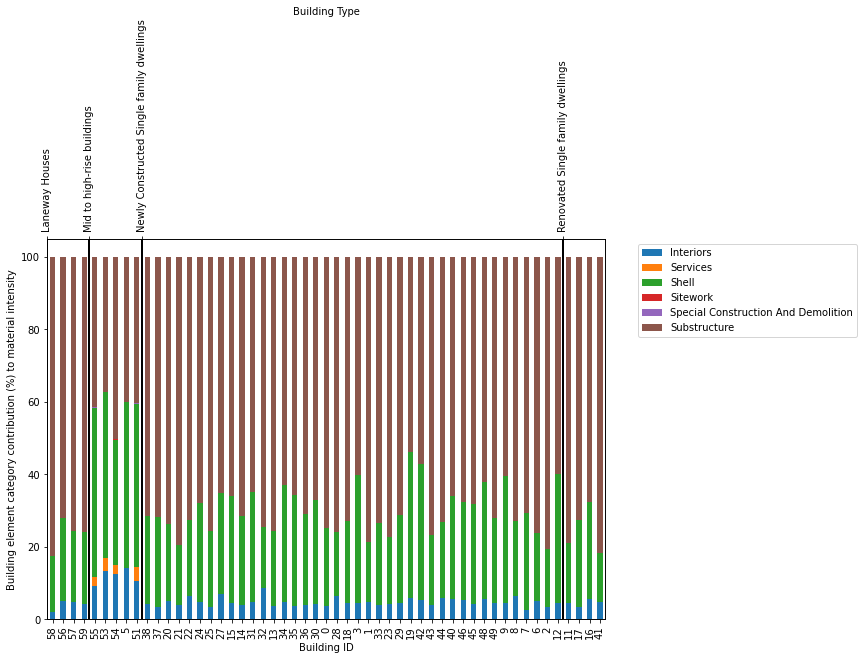

In [44]:
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)
df_mi = df_mi.div(df_mi.sum(axis=1),axis=0) * 100
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]]
toplot = pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1).sort_values('Building Type')
toplot = toplot[toplot['Building Type'].isin(types_to_keep)]
toplot['Building Type'] = toplot['Building Type'].replace(building_type_map)
toplot = toplot.sort_values('Building Type')
fig, ax = plt.subplots(figsize=(10,7))  

cols = toplot.columns[6:]
margin_bottom = np.zeros(len(toplot))

cmap = plt.get_cmap('tab10')

for num, col in enumerate(cols):
    values = toplot[col].values

    toplot[col].plot.bar(x='Year',y='Value', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=cmap(num), label=col)
    margin_bottom += values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Building ID')
plt.ylabel('Building element category contribution (%) to material intensity')

ax2 = ax.twiny()
ax2.set_xlim(0, len(toplot))
ax2.set_xticks([k for k,v in enumerate(toplot['Building Type'].values) if v != toplot['Building Type'].values[k-1] or k==0])
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
ax2.set_xticklabels([v for k,v in enumerate(toplot['Building Type'].values) if v != toplot['Building Type'].values[k-1] or k==0])
ax2.set_xlabel("Building Type")
plt.grid(color='black',linewidth=2)
plt.show()

In [45]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]] + '/' + re.split('[_\.\ ]',x)[-1]
toplot = df_mi[kilogram_columns].groupby(f,axis=1).sum()

In [46]:
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)
df_mi = df_mi.div(df_mi.sum(axis=1),axis=0)
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]] + '/' + re.split('[_\.\ ]',x)[-1]
toplot = df_mi[kilogram_columns].groupby(f,axis=1).sum()
for i in range(1,5):
    toplot[f'Total/{i}'] = 0
for k,v in toplot.iteritems():
    toplot[f'Total/{k.split("/")[1]}'] += v
toplot_out = deepcopy(toplot)
for k,v in toplot.iteritems():
    toplot_out[k] = (v/toplot[[c for c in toplot.columns if k.split('/')[0] in c]].sum(axis=1)) * int(k.split('/')[1])
f = lambda x: x.split('/')[0]
toplot_out = pd.concat([df['Building Type'],toplot_out.groupby(f,axis=1).sum()],axis=1).sort_values('Building Type')
toplot_out = toplot_out.reset_index()
toplot_out['index'] += 1
toplot_out['index'] = toplot_out['index'].astype('str')

In [47]:
toplot_out = toplot_out[toplot_out['Building Type'].isin(types_to_keep)]
toplot_out['Building Type'] = toplot_out['Building Type'].replace(building_type_map)
toplot_out = toplot_out.sort_values('Building Type')

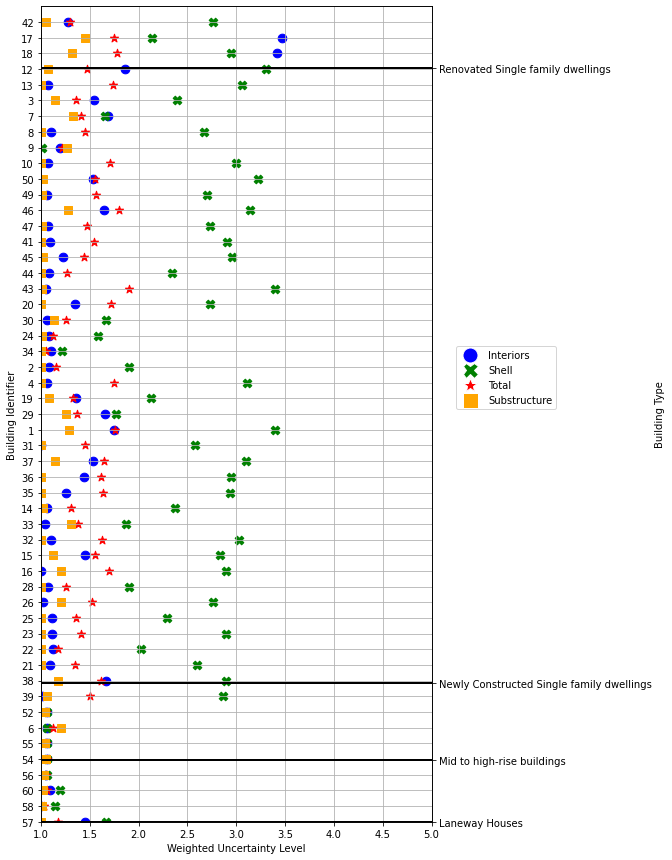

In [48]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(7,15)) 
ax.set_xlim(1,5)
ax.set_ylim(1,len(toplot_out))
# ax.set_yticks(toplot_out['index'])
handles = []
for v,m,c in [('Interiors','o','blue'),('Shell','X','green'),('Total','*','red'),('Substructure','s','orange')]:
    ax.scatter(x=toplot_out[v].values,y=toplot_out['index'].values, marker=m, color=c, s=75)
    handles.append(
        Line2D([0], [0], marker=m, color='w', label=v,
                              markerfacecolor=c, markersize=15)
    )
plt.legend(handles=handles,bbox_to_anchor=(1.05, 0.5), loc='lower left')
plt.ylabel('Building Identifier')
plt.xlabel('Weighted Uncertainty Level')
plt.grid()
ax2 = ax.twinx()
ax2.set_ylim(0, len(toplot_out))
ax2.set_yticks([k for k,v in enumerate(toplot_out['Building Type'].values) if v != toplot_out['Building Type'].values[k-1] or k==0])
# for tick in ax2.get_yticklabels():
#     tick.set_rotation(90)
ax2.set_yticklabels([v for k,v in enumerate(toplot_out['Building Type'].values) if v != toplot_out['Building Type'].values[k-1] or k==0])
ax2.set_ylabel("Building Type")


plt.grid(color='black',linewidth=2)

In [51]:
toplot_out

,index,Building Type,Interiors,Services,Shell,Sitework,Special Construction And Demolition,Substructure,Total
11,59,Laneway Houses,1.000000,0.000000,1.222478,0.000000,0.000000,1.009829,1.042591
10,57,Laneway Houses,1.448192,0.000000,1.667883,0.000000,0.000000,1.005174,1.178813
9,58,Laneway Houses,1.000000,0.000000,1.139704,0.000000,0.000000,1.007530,1.033101
8,60,Laneway Houses,1.096416,0.000000,1.190118,0.000000,0.000000,1.024279,1.060490
0,56,Mid to high-rise buildings,1.055282,1.063345,1.066190,0.000000,1.000000,1.030704,1.050220
3,54,Mid to high-rise buildings,1.058893,1.063345,1.063330,1.063345,0.000000,1.051582,1.058344
2,55,Mid to high-rise buildings,1.060142,1.063345,1.063332,1.063345,0.000000,1.038912,1.050663
1,6,Mid to high-rise buildings,1.064886,1.000000,1.062593,0.000000,0.000000,1.204492,1.119946
4,52,Mid to high-rise buildings,1.059125,1.063345,1.062897,0.000000,1.063345,1.039532,1.053064
46,39,Newly Constructed Single family dwellings,1.014009,0.000000,2.868481,0.000000,0.000000,1.059205,1.497711
